In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
COMPETION_DATA_DIR = '/content/drive/MyDrive/input/kaggle/feedback-prize-english-language-learning'
iter_path = COMPETION_DATA_DIR + '/iterativestratification'

In [3]:
!pip install tokenizers
!pip install transformers
!pip install iterstrat
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.1 MB/s 
     |████████████████████████████████| 182 kB 54.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement iterstrat (from versions: none)
ERROR: No matching distribution found for iterstrat
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.1 MB/s 


In [4]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [5]:
import numpy as np
import pandas as pd
import os
import os
import gc
import re
import ast
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
sys.path.append(iter_path)
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils import checkpoint
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import sentencepiece

env: TOKENIZERS_PARALLELISM=true


In [6]:
class CFG:
    eda = False
    debug = False
    load_bert_data = False
    load_test_only = False
    model_train = False
    train_multi = True
    train_staking = False
    train_ensumbling = True
    headrow = 3
    num_workers=4
    gradient_checkpointing=True
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=8
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    seed=42
    n_fold=25
    train=True
    
if CFG.debug:
    CFG.n_fold = 5
    
if CFG.train_staking == False & CFG.train_ensumbling == False:
    CFG.train_ensumbling = True

In [7]:
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions',]

In [8]:
# def get_logger(filename=OUTPUT_DIR + 'train'):
#     from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
#     logger = getLogger(__name__)
#     logger.setLevel(INFO)
#     handler1 = StreamHandler()
#     handler1.setFormatter(Formatter("%(message)s"))
#     handler2 = FileHandler(filename=f"{filename}.log")
#     handler2.setFormatter(Formatter("%(message)s"))
#     logger.addHandler(handler1)
#     logger.addHandler(handler2)
#     return logger


# LOGGER = get_logger()


def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(seed=42)


def get_essay(essay_id, is_train=True):
    parent_path = INPUT_DIR + 'train' if is_train else INPUT_DIR + 'test'

    try:
        essay_path = os.path.join(parent_path, f"{essay_id}.txt")
        essay_text = open(essay_path, 'r').read()
        return essay_text
    except:
        return ''

def criterion_val(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)


def criterion_train(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [9]:
from transformers import AutoModel,AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [10]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [11]:
BATCH_SIZE = 4

class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx,"full_text"]
        tokens = tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=MAX_LEN,return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens



In [12]:
tokenizer = None
MAX_LEN = 640

def get_embeddings(MODEL_NM='', MAX=640, BATCH_SIZE=4, verbose=True):
    global tokenizer, MAX_LEN
    DEVICE="cuda"
    model = AutoModel.from_pretrained( MODEL_NM )
    tokenizer = AutoTokenizer.from_pretrained( MODEL_NM )
    MAX_LEN = MAX
    
    model = model.to(DEVICE)
    model.eval()
    all_train_text_feats = []
    for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
        all_train_text_feats.extend(sentence_embeddings)
    all_train_text_feats = np.array(all_train_text_feats)
    if verbose:
        print('Train embeddings shape',all_train_text_feats.shape)

        
    return all_train_text_feats

In [13]:
INPUT_DIR = '/content/drive/MyDrive/input/kaggle/feedback-prize-effectiveness/'

In [14]:
train = pd.read_csv(INPUT_DIR + 'train.csv')
if CFG.debug:
    train = train[:1000]
test = pd.read_csv(INPUT_DIR + 'test.csv')
print(train.head())
print(train.shape)
print(test.head())
print(test.shape)

   discourse_id      essay_id                                     discourse_text discourse_type discourse_effectiveness
0  0013cc385424  007ACE74B050  Hi, i'm Isaac, i'm going to be writing about h...           Lead                Adequate
1  9704a709b505  007ACE74B050  On my perspective, I think that the face is a ...       Position                Adequate
2  c22adee811b6  007ACE74B050  I think that the face is a natural landform be...          Claim                Adequate
3  a10d361e54e4  007ACE74B050  If life was on Mars, we would know by now. The...       Evidence                Adequate
4  db3e453ec4e2  007ACE74B050  People thought that the face was formed by ali...   Counterclaim                Adequate
(36765, 5)
   discourse_id      essay_id                                     discourse_text discourse_type
0  a261b6e14276  D72CB1C11673  Making choices in life can be very difficult. ...           Lead
1  5a88900e7dc1  D72CB1C11673  Seeking multiple opinions can help a person ma

In [15]:
pseudo_train = train['essay_id'].drop_duplicates().reset_index(drop = False)

In [ ]:
pseudo_train['full_text'] = pseudo_train['essay_id'].apply(lambda x: get_essay(x, is_train=True))

In [ ]:
pseudo_train.head()

In [ ]:
!pip install readability

In [ ]:
import readability
import pandas as pd
import re
import seaborn as sns

In [ ]:
def data_cleaner(text):
    text = text.strip()
    text = re.sub(r'\n', '', text)
    text = text.lower()
    return text

In [ ]:
def calc_readability(text):

    results = readability.getmeasures(text, lang='en')

    return results['readability grades']['ARI']

In [ ]:
pseudo_train['full_text'] = pseudo_train['full_text'].apply(data_cleaner)
pseudo_train['readability'] = pseudo_train['full_text'].apply(calc_readability)
pseudo_train['words'] = pseudo_train['full_text'].apply(lambda x: len(x.split()))

In [ ]:
pseudo_train.head()

In [ ]:
sns.pairplot(pseudo_train)

In [ ]:
min_readability = 92.793281
max_readability = 396.656655
min_words = 185.000000
max_words = 783.000000

In [ ]:
pseudo_train = pseudo_train[
    (pseudo_train['readability'] >= min_readability)
    &(pseudo_train['readability'] <= max_readability)
    &(pseudo_train['words'] >= min_words)
    &(pseudo_train['words'] <= max_words)
].reset_index(drop = True)

In [ ]:
pseudo_train.shape

In [ ]:
pseudo_train.shape

In [ ]:
pseudo_train_std_df = pd.DataFrame()
pseudo_train_std_df['essay_id'] = sub['essay_id']
pseudo_train_std_df['full_text'] = sub['full_text']
for t in target_cols: 

    calc_mean = np.mean(final_pred[t], axis = 1)
    pseudo_train_std_df[t+'_mean'] = calc_mean

    calc_std = np.std(final_pred[t], axis = 1)
    pseudo_train_std_df[t+'_std'] = calc_std

In [ ]:
pseudo_train_std_df

In [ ]:
pseudo_train_std_df['std_sum'] = 0
for t in target_cols: 
    pseudo_train_std_df['std_sum'] += pseudo_train_std_df[t+'_std']
pseudo_train_std_df

,essay_id,full_text,cohesion,cohesion_std,syntax,syntax_std,vocabulary,vocabulary_std,phraseology,phraseology_std,grammar,grammar_std,conventions,conventions_std,std_sum
0,007ACE74B050,"hi, i'm isaac, i'm going to be writing about h...",2.753898,0.600023,3.268645,0.182921,3.360667,0.117214,3.207172,0.162147,3.318322,0.106436,2.797132,0.400213,1.568954
1,00BD97EA4041,should computers read the emotional expression...,2.995694,0.179364,3.167780,0.079624,3.356517,0.230893,3.117576,0.241731,3.408738,0.189975,2.914145,0.211276,1.132862
2,00C6E82FE5BA,i think that it wouldn't be valueable to have ...,2.887431,0.406383,3.071074,0.078696,3.238642,0.083750,3.272675,0.079400,3.431107,0.129229,2.838618,0.114731,0.892189
3,013B9AA6B9DB,"what is that thing on mars?well, some people b...",3.444617,0.134503,3.657184,0.226235,4.015621,0.192460,3.823907,0.202496,3.924430,0.176951,3.441164,0.130580,1.063224
4,0158970BC5D2,students around the world are forgetting more ...,3.888839,0.187062,4.200433,0.308184,4.173569,0.198660,4.146460,0.226964,4.324752,0.339947,3.891109,0.210707,1.471523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3551,FAA9FC1B315B,in my personal opinion when some schools offer...,3.217614,0.069842,2.920644,0.116273,3.295161,0.092676,3.340374,0.177390,3.104800,0.118110,2.717891,0.130591,0.704882
3552,FB56AA75F65F,"when someone needs advice, would it be benefic...",3.926621,0.188710,3.905008,0.146708,3.974578,0.137385,3.943331,0.153810,4.109823,0.164409,3.906483,0.143691,0.934713
3553,FD8A9514C8BC,not too long ago i got into a disagreement wit...,3.525431,0.222361,3.818564,0.090882,3.857144,0.182728,3.818472,0.197366,3.942404,0.115275,3.666800,0.235970,1.044583
3554,FE3CA06DDCA1,why is it when someone asks you for advice the...,2.877086,0.092587,2.864727,0.101861,2.963975,0.171031,3.056144,0.110402,2.950227,0.171163,2.523939,0.192851,0.839895


In [ ]:
pseudo_train_std_df = pseudo_train_std_df.sort_values('std_sum')
pseudo_train_std_df

,essay_id,full_text,cohesion,cohesion_std,syntax,syntax_std,vocabulary,vocabulary_std,phraseology,phraseology_std,grammar,grammar_std,conventions,conventions_std,std_sum
407,44E2726DA1B3,your principal has decided all students must p...,3.058810,0.072495,2.974407,0.091939,3.238400,0.084547,3.269352,0.072833,3.249493,0.102046,2.860877,0.051080,0.474940
3426,763EF698F56B,well in this part i think is good and bad idea...,2.628276,0.059763,2.437623,0.076222,2.839958,0.064263,2.473224,0.136544,2.280422,0.061474,2.653192,0.077371,0.475638
3252,FABE0E966789,"dear, principalstudents may bring there phones...",3.003166,0.064122,3.046374,0.058442,3.178563,0.054689,3.073753,0.129430,3.335048,0.088890,3.005114,0.085540,0.481114
2630,9E2E1FDE4D15,"dear mr principal,i think students are require...",3.096685,0.102367,3.166997,0.057771,3.264070,0.075699,3.251901,0.063841,3.338164,0.091197,3.206646,0.115986,0.506862
2137,558299F3D69E,dear principali think that we shouldn't have t...,3.005186,0.089006,3.085386,0.061448,3.339216,0.097226,3.209182,0.077375,3.298208,0.084993,3.065720,0.106675,0.516723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,2022B8E2B360,to principal i think we can help this communit...,2.051393,0.562419,1.957941,0.660819,2.484720,0.358802,2.331776,0.370354,2.005225,0.642399,2.002990,0.520998,3.115791
3549,FA1CE35CA43F,hook: talking to more than one person when see...,2.877751,0.622309,2.936032,0.454259,3.249229,0.477931,2.989015,0.441467,3.150666,0.496319,3.033654,0.642412,3.134696
2382,769FAE6984B9,has the face on mars been put there by alien? ...,2.578365,0.761560,2.975940,0.458327,2.942216,0.440495,2.616386,0.381850,2.774460,0.504381,2.516047,1.074578,3.621192
1445,F92664C55FBB,should you be able to text and drive?your frie...,2.793164,0.604544,2.844470,0.668744,2.857097,0.648396,2.601302,0.389773,2.747032,0.534254,2.779732,0.900383,3.746095


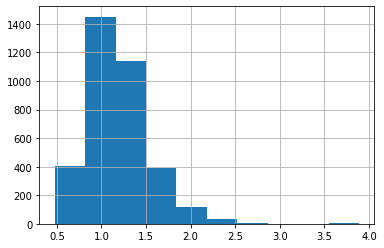

In [ ]:
pseudo_train_std_df['std_sum'].hist()

In [ ]:
len(pseudo_train_std_df[pseudo_train_std_df['std_sum'] <= 1])

1076

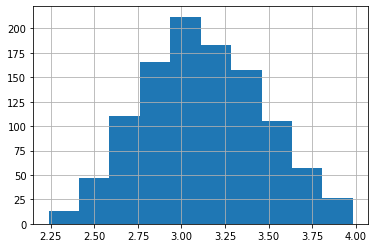

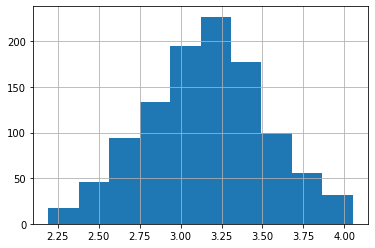

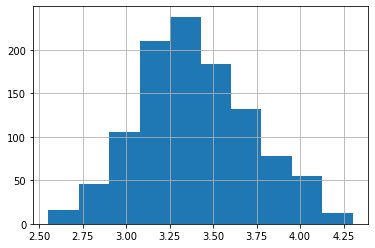

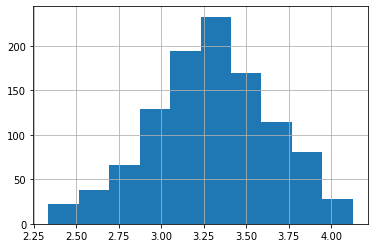

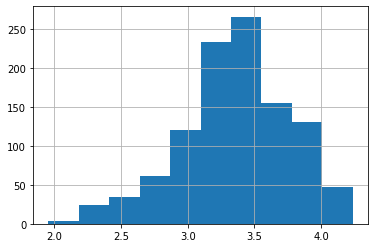

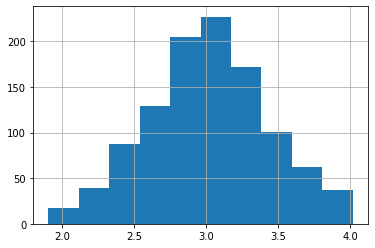

In [ ]:
for t in target_cols: 
    pseudo_train_std_df[pseudo_train_std_df['std_sum'] <= 1][t].hist()
    plt.show()

In [ ]:
pseudo_output_df = pseudo_train_std_df[pseudo_train_std_df['std_sum'] <= 1]
pseudo_output_df.head()

In [ ]:
target_cols

['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
pseudo_output_df = pseudo_output_df[['essay_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].rename(columns = {'essay_id':'text_id'})
pseudo_output_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
407,44E2726DA1B3,your principal has decided all students must p...,3.058810,2.974407,3.238400,3.269352,3.249493,2.860877
3426,763EF698F56B,well in this part i think is good and bad idea...,2.628276,2.437623,2.839958,2.473224,2.280422,2.653192
3252,FABE0E966789,"dear, principalstudents may bring there phones...",3.003166,3.046374,3.178563,3.073753,3.335048,3.005114
2630,9E2E1FDE4D15,"dear mr principal,i think students are require...",3.096685,3.166997,3.264070,3.251901,3.338164,3.206646
2137,558299F3D69E,dear principali think that we shouldn't have t...,3.005186,3.085386,3.339216,3.209182,3.298208,3.065720


In [ ]:
for t in target_cols: 
    pseudo_output_df[t] = np.round(pseudo_output_df[t]*2, 0) / 2
pseudo_output_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
407,44E2726DA1B3,your principal has decided all students must p...,3.0,3.0,3.0,3.5,3.0,3.0
3426,763EF698F56B,well in this part i think is good and bad idea...,2.5,2.5,3.0,2.5,2.5,2.5
3252,FABE0E966789,"dear, principalstudents may bring there phones...",3.0,3.0,3.0,3.0,3.5,3.0
2630,9E2E1FDE4D15,"dear mr principal,i think students are require...",3.0,3.0,3.5,3.5,3.5,3.0
2137,558299F3D69E,dear principali think that we shouldn't have t...,3.0,3.0,3.5,3.0,3.5,3.0


In [ ]:
pseudo_output_df.to_csv(COMPETION_DATA_DIR + '/pseudo_train2.csv', index = False)

In [ ]:
pseudo_train_text_feats = np.load('/content/drive/MyDrive/input/kaggle/feedback-prize-effectiveness/pseudo_train_text_feats.npy')

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR

In [ ]:
if CFG.train_multi == True:
    models = {
        # 'SVR(C=1)':SVR(C=1), 
        'Ridge(alpha=1)':Ridge(alpha=1), 
        # 'Lasso(alpha=1)':Lasso(alpha=1), 
        'RFR(max_depth=5, n_estimators=10)':RFR(max_depth=5, n_estimators=10),
        'Ridge(alpha=0.01)':Ridge(alpha=0.01), 
        'RFR(max_depth=3, n_estimators=10)':RFR(max_depth=3, n_estimators=10)
    }
else:
    models = {
        'Ridge(alpha=1)':Ridge(alpha=1), 
    }

In [ ]:
FOLDS = CFG.n_fold

np.save('/content/drive/MyDrive/input/kaggle/feedback-prize-effectiveness/pseudo_train_text_feats', pseudo_train_text_feats)

In [ ]:
from sklearn.metrics import mean_squared_error

preds = []
scores = []
stacks = []
def comp_score(y_true,y_pred):
    rmse_scores = []
    for i in range(len(target_cols)):
        rmse_scores.append(np.sqrt(mean_squared_error(y_true[:,i],y_pred[:,i])))
    return np.mean(rmse_scores)

for model in models.keys():

    #for fold in tqdm(range(FOLDS),total=FOLDS):
    for fold in range(FOLDS):
        print('#'*25)
        print('### Fold',fold)
        print('#'*25)
        
        # dftr_ = dftr[dftr["FOLD"]!=fold]
        # dfev_ = dftr[dftr["FOLD"]==fold]
        
        # tr_text_feats = all_train_text_feats[list(dftr_.index),:]
        # ev_text_feats = all_train_text_feats[list(dfev_.index),:]
        
        # ev_preds = np.zeros((len(ev_text_feats),6))
        test_preds = np.zeros((len(pseudo_train_text_feats),6))
        # stack_preds = np.zeros((len(all_train_text_feats[list(dftr.index),:]),6))
        
        for i,t in enumerate(target_cols):

            if CFG.model_train == True:
                pass
                # print(t,', ',end='')
                # clf = models[model]
                # clf.fit(tr_text_feats, dftr_[t].values)
                # ev_preds[:,i] = clf.predict(ev_text_feats)
                # test_preds[:,i] = clf.predict(te_text_feats)
                # stack_preds[:,i] = clf.predict(all_train_text_feats[list(dftr.index),:])

                # # モデルを保存する
                # if 'google.colab' in sys.modules:
                #     filename = f'{COMPETION_DATA_DIR}/models/finalized_{model}_{t}_{fold}.sav'
                # elif 'kaggle_web_client' in sys.modules:
                #     filename = f'finalized_{model}_{t}_{fold}.sav'
                # pickle.dump(clf, open(filename, 'wb'))

            else:
     
                filename = f'{COMPETION_DATA_DIR}/models/{model}_{t}_{fold}.sav'.replace('=', '_')
                clf = pickle.load(open(filename, 'rb'))
                # ev_preds[:,i] = clf.predict(ev_text_feats)
                test_preds[:,i] = clf.predict(pseudo_train_text_feats)
                # stack_preds[:,i] = clf.predict(all_train_text_feats[list(dftr.index),:])
            
            gc.collect()

        print()
        # score = comp_score(dfev_[target_cols].values,ev_preds)
        # scores.append(score)
        
        # stacks.append(stack_preds)
        
        # print("Fold : {} RSME score: {}".format(fold,score))
        preds.append(test_preds)
    
print('#'*25)
print('Overall CV RSME =',np.mean(scores))

#########################
### Fold 0
#########################

#########################
### Fold 1
#########################

#########################
### Fold 2
#########################

#########################
### Fold 3
#########################

#########################
### Fold 4
#########################

#########################
### Fold 5
#########################

#########################
### Fold 6
#########################

#########################
### Fold 7
#########################

#########################
### Fold 8
#########################

#########################
### Fold 9
#########################

#########################
### Fold 10
#########################

#########################
### Fold 11
#########################

#########################
### Fold 12
#########################

#########################
### Fold 13
#########################

#########################
### Fold 14
#########################

#########################
### Fold 

In [ ]:

sub = pseudo_train.copy()
final_pred = {}

for i,t in enumerate(target_cols): 
    
    ensumbe_final_pred = pd.DataFrame()
    # ensumbe_final_pred_mean = pd.DataFrame()

    for ii in range(FOLDS*len(models)):
        ensumbe_final_pred = pd.concat([ensumbe_final_pred, pd.DataFrame(preds[ii], columns = target_cols)[t]], axis = 1)
    #     display(pd.DataFrame(preds[ii], columns = target_cols).head())
    # display(ensumbe_final_pred.head())
    # ensumbe_final_pred['essay_id'] = sub['essay_id']
    final_pred[t] = ensumbe_final_pred

    # for jj in range(1, len(models)+1):
    #     ensumbe_final_pred_mean = pd.concat([ensumbe_final_pred_mean, ensumbe_final_pred.iloc[:, CFG.n_fold * (jj-1): CFG.n_fold * (jj)].mean(axis = 1)], axis = 1)

    # if ensumbe_final_pred_mean.shape[1] >= 2:
    #     sub[t] = np.mean(ensumbe_final_pred_mean, axis=1)
    # else:
    #     sub[t] = ensumbe_final_pred_mean

# sub_columns = list(set(pseudo_train.columns) | set(target_cols))
# sub = sub[sub_columns]
# sub.head()